# Practical session 3 - Brownian motion, Fourier transform

Students (pair):
- [Alexandre LECOMTE](https://github.com/tribulle)
- [Serina TRAORE](https://github.com/SerinaTraore)


**Useful references for this lab**:

[1] scikit-learn: [documentation](https://scikit-learn.org/stable/modules/neighbors.html?highlight=knn%20classification)

[2] `numba`: [documentation](http://numba.pydata.org/) 

[3] cython: [a very useful tutorial](https://cython.readthedocs.io/en/latest/src/userguide/numpy_tutorial.html#numpy-tutorial), and [another one](http://docs.cython.org/en/latest/src/tutorial/cython_tutorial.html)



## <a name="content">Contents</a>
- [Exercise 1: KNN classification with numpy and sklearn](#ex1)
- [Exercise 2: Code acceleration with cython](#ex2)
- [Exercise 3: Code acceleration with numba](#ex3)
---

In [1]:
%load_ext autoreload
%autoreload 2

## <a name="ex1">Exercise 1: K-Nearest Neighbours (K-NN) classification with numpy and scikit-learn</a> [(&#8593;)](#content)

This session is a first introduction to classification using the most intuitive non parametric method: the $K$-nearest neighbours. The principle is [the following](https://scikit-learn.org/stable/modules/neighbors.html?highlight=knn%20classification). A set of labelled observations is given as a learning set. A classification taks then consists in assigning a label to any new observation. In particular, the K-NN approach consists in assigning to the observation the most frequent label among its $K$ nearest neighbours taken in the training set.

### A. Validation on synthetic data

Load the training and test datasets `data/synth_train.txt` and `data/synth_test.txt`. Targets belong to the set $\{1,2\}$ and entries belong to $\mathbb{R}^2$. The file `data/synth_train.txt` contain 100 training data samples, and `data/synth_test.txt` contains 200 test samples, where:

- the 1st column contains the label of the class the sample;
- columns 2 & 3 contain the coordinates of each sample (in $\mathbb{R}^2$).

Useful commands can be found below.

```python
# load the training set
train = np.loadtxt('data/synth_train.txt')  #...,delimiter=',') if there are ',' as delimiters
class_train = train[:,0]
x_train = train[:,1:]
N_train = train.shape[0]
```

```python
# load the test set
test = np.loadtxt('/datasynth_test.txt') 
class_test_1 = test[test[:,0]==1]
class_test_2 = test[test[:,0]==2]
x_test = test[:,1:]
N_test = test.shape[0]
```

In [182]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import bottleneck as bn
from sklearn.neighbors import KNeighborsClassifier
import timeit
test = np.loadtxt('data/synth_test.txt')
class_test_1 = test[test[:,0]==1]
class_test_2 = test[test[:,0]==2]
x_test = test[:,1:]
N_test = test.shape[0]

train = np.loadtxt('data/synth_train.txt')  #...,delimiter=',') if there are ',' as delimiters
class_train = train[:,0]
x_train = train[:,1:]
N_train = train.shape[0]

1\. Display the training set and distinguish the two classes. 

> Hint: useful functions include `matplotlib.pyplot.scatter` or `matplotlib.pyplot.plot`.

**Answer:**

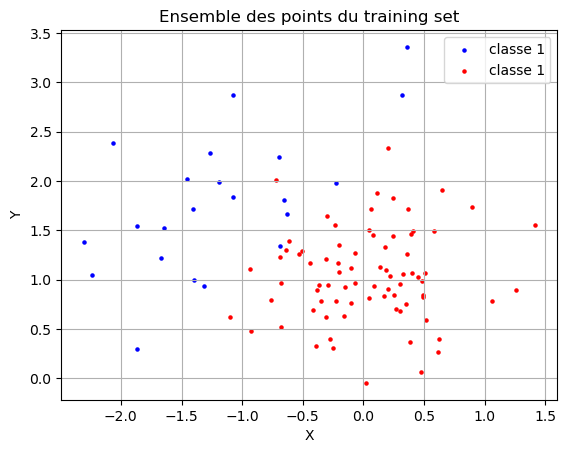

In [192]:
plt.scatter(train[train[:, 0] == 1][:, 1], train[train[:, 0] == 1][:, 2], c='blue', s=5, label='classe 1')
plt.scatter(train[train[:, 0] == 2][:, 1], train[train[:, 0] == 2][:, 2], c='red', s=5, label='classe 1')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Ensemble des points du training set')
plt.legend()
plt.grid()
plt.show()

2\. Implement the K-nearest neighbours algorithm for classification.

> Hint: 
> - useful functions include `numpy.linalg.norm`, `numpy.argsort`, `numpy.bincount`;
> - implement the algorithm as a function rather than an object. This will drastically simplify the acceleration step using Cython.
> - for an optimized partial sorting procedure, you may have a look at the [`bottleneck.argpartition` function](https://bottleneck.readthedocs.io/en/latest/reference.html#bottleneck.argpartition).
> 1. Compute for each row in `x_test` (if necessary use `np.newaxis`) its distance with respect to `x_train`:
>  - Use  `numpy.linalg.norm` (in which dimension this distance is computed ? Consider using `axis` argument)
> 2. Sort the ordered collection of distances (indices from smallest to largest (in ascending order) by the distances):
>   - Use `np.argsort` (at the end replace this procedure by `bottleneck.argpartition`)
>   - Once the sorting is done, we take only the indices of `labels` of the `n_neighbours` nearest neighbours of the `class_train` :
>     - `id = np.argsort(distances)[:n_ neighbours]` and `labels = class_train[id]`
> 3. The K-nearest can be used for **Regression**, in this case it is necessary to return the mean of the K-labels. For **Classification**,  we return the mode of the K-labels :
> - Use `np.bincount` for `labels` to affect the variable `class_pred[q]` (for row `q`). This procedure counts the number of occurrences of each value in array. **Mode** is the value that appears. How can we get this value ?


**Answer:**

In [170]:
def knn_classification_argsort(x_train, class_train, x_test, k):
    distances = np.linalg.norm(x_test[:, np.newaxis] - x_train, axis=2)
    id = np.argsort(distances, axis=1)[:, :k]  # Indices des k plus petites distances
    labels = class_train[id].astype(int)
    class_pred = np.zeros(x_test.shape[0], dtype=int)

    for i in range(x_test.shape[0]):
        class_pred[i] = np.bincount(labels[i]).argmax()

    return class_pred

def knn_classification_argpartition(x_train, class_train, x_test, k):
    distances = np.linalg.norm(x_test[:, np.newaxis] - x_train, axis=2)
    id = bn.argpartition(distances, k, axis=1)[:, :k]
    labels = class_train[id].astype(int)
    class_pred = np.zeros(x_test.shape[0], dtype=int)

    for i in range(x_test.shape[0]):
        class_pred[i] = np.bincount(labels[i]).argmax()

    return class_pred



argsort_time = timeit.timeit(lambda: knn_classification_argsort(x_train, class_train, x_test, k), number=10)
print(f"Temps d'exécution avec np.argsort : {argsort_time:.5f} secondes")

# Mesure du temps pour la version avec bn.argpartition
argpartition_time = timeit.timeit(lambda: knn_classification_argpartition(x_train, class_train, x_test, k), number=10)
print(f"Temps d'exécution avec bn.argpartition : {argpartition_time:.5f} secondes")


Temps d'exécution avec np.argsort : 0.02949 secondes
Temps d'exécution avec bn.argpartition : 0.01394 secondes


Le temps d'exécution avec bn.argpartition est deux fois plus court que celui avec np.argsort. bn.argpartition réalise un tri partiel avec une complexité en O(n) tandis que arsort tri complètement la liste donc avec une complexité O(nlogn). Dans la suite on continue avec knn_classification_argparititon qu'on renomme simplement knn_classification

In [171]:
def knn_classification(x_train, class_train, x_test, k):
    distances = np.linalg.norm(x_test[:, np.newaxis] - x_train, axis=2)
    id = bn.argpartition(distances, k, axis=1)[:, :k]
    labels = class_train[id].astype(int)
    class_pred = np.zeros(x_test.shape[0], dtype=int)

    for i in range(x_test.shape[0]):
        class_pred[i] = np.bincount(labels[i]).argmax()

    return class_pred

3\. Compute the error rate on the training set and the test set for $K \in \{1,2, \dotsc, 20\}$. Display the classification result (see 1.) for the configuration with the lowest error rate.

**Answer:**

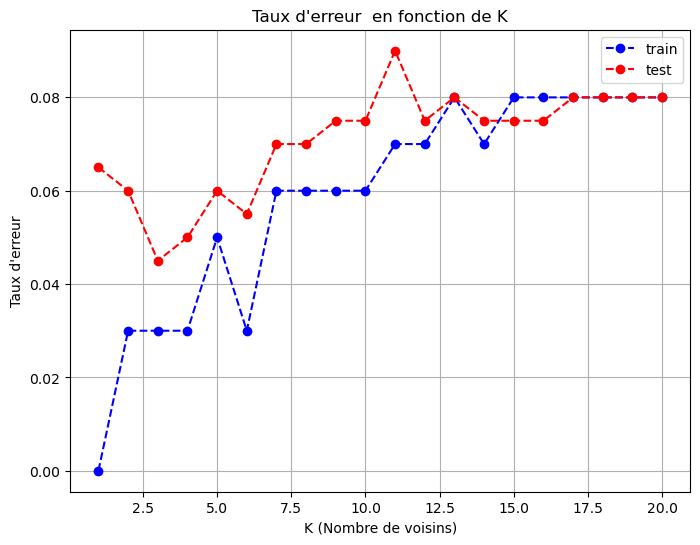

In [172]:
def compute_error_rate(y_true, y_pred):
    return np.mean(y_true != y_pred)

error_test_list = []
error_train_list = []
k_values = range(1, 21)


for k in k_values:
    class_pred_train = knn_classification(x_train, class_train, x_train, k)
    class_pred_test = knn_classification(x_train, class_train, x_test, k)
    error_test = compute_error_rate(test[:, 0], class_pred_test)
    error_test_list.append(error_test)
    error_train = compute_error_rate(train[:, 0], class_pred_train)
    error_train_list.append(error_train)

plt.figure(figsize=(8, 6))
plt.plot(k_values, error_train_list, color='blue', marker='o', linestyle='--', label='train')
plt.plot(k_values, error_test_list, color='red', marker='o', linestyle='--', label='test')
plt.title('Taux d\'erreur  en fonction de K')
plt.xlabel('K (Nombre de voisins)')
plt.ylabel('Taux d\'erreur')
plt.legend()
plt.grid(True)
plt.show()

4\. Comment on your results. Which value of $K$ seems optimal ?


**Answer:**

In [193]:
best_k_test = np.argmin(error_test_list) + 1
best_k_train = np.argmin(error_train_list) + 1

print(f"Meilleur K (plus faible taux d'erreur sur le test): {best_k_test}")
print(f"Taux d'erreur sur l'ensemble de test avec K={best_k_test}: {error_test_list[best_k_test - 1]}")

print(f"Meilleur K (plus faible taux d'erreur sur le train): {best_k_train}")
print(f"Taux d'erreur sur l'ensemble de train avec K={best_k_train}: {error_train_list[best_k_train - 1]}")

Meilleur K (plus faible taux d'erreur sur le test): 3
Taux d'erreur sur l'ensemble de test avec K=3: 0.045
Meilleur K (plus faible taux d'erreur sur le train): 1
Taux d'erreur sur l'ensemble de train avec K=1: 0.0


Le taux d'erreur sur l'ensemble d'entraînement est nul pour \( K = 1 \). Cela est parfaitement logique, car avec \( K = 1 \), chaque point de l'ensemble d'entraînement est classé en fonction de lui-même, ce qui conduit à une prédiction exacte pour tous les points. En d'autres termes, le modèle dispose déjà de toutes les informations sur l'ensemble d'entraînement, ce qui élimine toute erreur de classification.

En revanche, sur l'ensemble de test, le meilleur taux d'erreur est obtenu avec \( K = 3 \), avec un taux d'erreur de 0,045. Cela indique que \( K = 3 \) est un bon choix pour la généralisation, car il permet de mieux équilibrer la complexité du modèle et la précision sur des données nouvelles, comparé à \( K = 1 \), qui donne un taux important d'erreur dû au surrapprentissage 

5\. Compare the results of you implementation with those of [`sklearn.neighbors.KNeighborsClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html?highlight=kneighborsclassifier#sklearn.neighbors.KNeighborsClassifier). Compare the runtime of these two versions using the [`timeit`](https://docs.python.org/3/library/timeit.html) module (see session 1).

**Answer:**

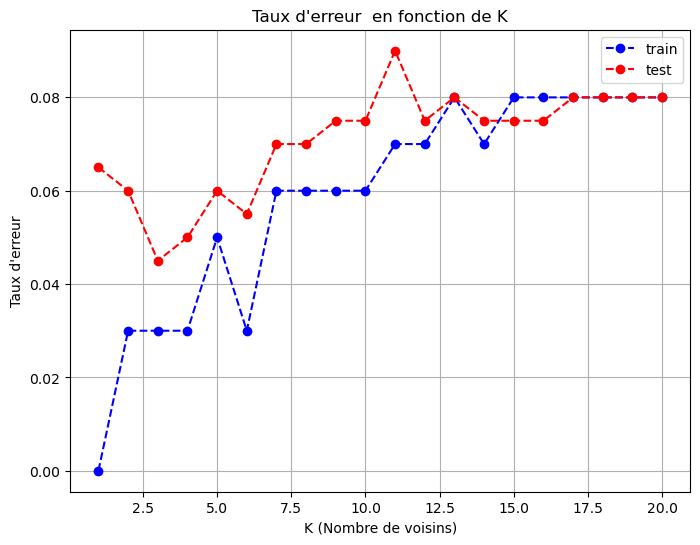

In [19]:
error_test_list = []
error_train_list = []
k_values = range(1, 21)


for k in k_values:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(x_train, class_train)
    class_pred_train = knn_model.predict(x_train)
    class_pred_test = knn_model.predict(x_test)
    error_test = compute_error_rate(test[:, 0], class_pred_test)
    error_test_list.append(error_test)
    error_train = compute_error_rate(train[:, 0], class_pred_train)
    error_train_list.append(error_train)

plt.figure(figsize=(8, 6))
plt.plot(k_values, error_train_list, color='blue', marker='o', linestyle='--', label='train')
plt.plot(k_values, error_test_list, color='red', marker='o', linestyle='--', label='test')
plt.title('Taux d\'erreur  en fonction de K')
plt.xlabel('K (Nombre de voisins)')
plt.ylabel('Taux d\'erreur')
plt.legend()
plt.grid(True)
plt.show()

On constate qu'on obtient exactement la même courbe qu'avec notre propre implémentation de l'algorithme KNN

In [133]:
def test_manual_knn():
    error_test_list = []
    error_train_list = []
    for k in k_values:
        class_pred_train = knn_classification(x_train, class_train, x_train, k)
        class_pred_test = knn_classification(x_train, class_train, x_test, k)
        error_test = compute_error_rate(test[:, 0], class_pred_test)
        error_test_list.append(error_test)
        error_train = compute_error_rate(train[:, 0], class_pred_train)
        error_train_list.append(error_train)
    return error_test_list, error_train_list

def test_sklearn_knn():
    error_test_list = []
    error_train_list = []
    for k in k_values:
        knn_model = KNeighborsClassifier(n_neighbors=k)
        knn_model.fit(x_train, class_train)
        class_pred_train = knn_model.predict(x_train)
        class_pred_test = knn_model.predict(x_test)
        error_test = compute_error_rate(test[:, 0], class_pred_test)
        error_test_list.append(error_test)
        error_train = compute_error_rate(train[:, 0], class_pred_train)
        error_train_list.append(error_train)
    return error_test_list, error_train_list

manual_time = timeit.timeit(test_manual_knn, number=10, globals=globals())
print(f"Temps d'exécution de la version manuelle : {manual_time:.5f} secondes")
sklearn_time = timeit.timeit(test_sklearn_knn, number=10, globals=globals())
print(f"Temps d'exécution de la version sklearn : {sklearn_time:.5f} secondes")

Temps d'exécution de la version manuelle : 0.32091 secondes
Temps d'exécution de la version sklearn : 1.77531 secondes


Les temps d'exécution montrent que la version manuelle est plus rapide  que la version `scikit-learn` pour cet ensemble de données. Cela peut s'expliquer par le fait que la version manuelle est spécifiquement optimisée pour ce cas simple, tandis que `scikit-learn` inclut des fonctionnalités supplémentaires et une plus grande flexibilité, ce qui introduit une surcharge computationnelle. 

### B. Application to a real dataset (Breast cancer Wisconsin).

6\. Apply the K-NN classifier to the real dataset `data/wdbc12.data.txt.` Further details about the data are provided in `data/wdbc12.names.txt`.

> Hint: you can use the function [`train_test_split` from `sklearn.model_selection`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to split the dataset into a training and a test set.

**Answer:**

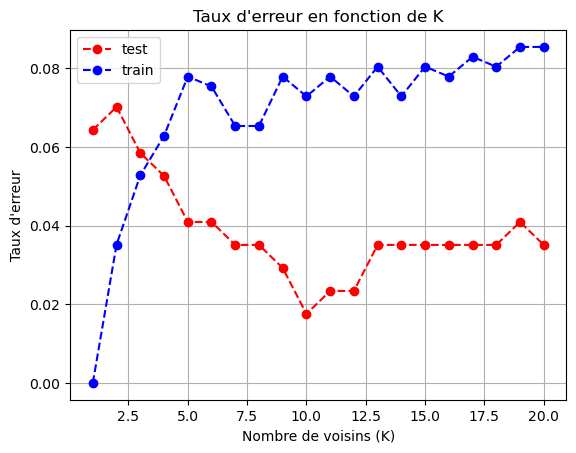

In [85]:
from sklearn.model_selection import train_test_split
data = np.loadtxt('data/wdbc12.data.txt', delimiter=',')[:,1:]
y = data[:, 0]
X = data[:, 1:].astype(float)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

error_test_list = []
error_train_list = []
k_values = range(1, 21)

for k in k_values:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train, y_train)
    class_pred_train = knn_model.predict(X_train)
    class_pred_test = knn_model.predict(X_test)
    error_test = compute_error_rate(class_pred_test, y_test)
    error_train = compute_error_rate(class_pred_train, y_train)
    error_test_list.append(error_test)
    error_train_list.append(error_train)

plt.plot(k_values, error_test_list, color='red', marker='o', linestyle='--', label='test')
plt.plot(k_values, error_train_list, color='blue', marker='o', linestyle='--', label='train')
plt.title("Taux d'erreur en fonction de K")
plt.xlabel('Nombre de voisins (K)')
plt.ylabel("Taux d'erreur")
plt.grid()
plt.legend()
plt.show()


In [31]:
best_k_test = np.argmin(error_test_list) + 1
best_k_train = np.argmin(error_train_list) + 1

print(f"Meilleur K (plus faible taux d'erreur sur le test): {best_k_test}")
print(f"Taux d'erreur sur l'ensemble de test avec K={best_k_test}: {error_test_list[best_k_test - 1]}")

print(f"Meilleur K (plus faible taux d'erreur sur le train): {best_k_train}")
print(f"Taux d'erreur sur l'ensemble de train avec K={best_k_train}: {error_train_list[best_k_train - 1]}")

Meilleur K (plus faible taux d'erreur sur le test): 3
Taux d'erreur sur l'ensemble de test avec K=3: 0.045
Meilleur K (plus faible taux d'erreur sur le train): 1
Taux d'erreur sur l'ensemble de train avec K=1: 0.0


On constate une fois de plus que sur l'ensemble de train la valeur optimale est K = 1.

## <a name="ex2">Exercise 2: Code acceleration with cython</a> [(&#8593;)](#content)

Cython allows C code to be easily interfaced with Python. It can be useful to make your code faster for a small coding effort, in particular when using loops. A general approach to optimize your code is outlined in the [Scipy lecture notes, Section 2.4](https://scipy-lectures.org/advanced/optimizing/index.html). Complementary reading about interfacing Python with C can be found in [Section 2.8](https://scipy-lectures.org/advanced/interfacing_with_c/interfacing_with_c.html).

1\. Read carefully the [cython tutorial](http://docs.cython.org/en/latest/src/tutorial/cython_tutorial.html), which describes step by the step how the toy example reported below has been developed.

**Setup**: Compile the toy example provided in `example_cy/` by running, in the command line (anaconda prompt on windows)

```bash
cd example_cy && python setup.py build_ext --inplace
```

Note that the compilation process has been slightly automatised with the instructions reported in `example_cy/setup.py`. To test the module, run

In [4]:
!cd example_cy && python setup.py build_ext --inplace

which should display
```python
Hello World
```

> Warning: 
> - do not forget to include an empty `__init__.py` file in the directory where your source code lives (`import` will fail if this is not the case).
> - in case you have any setup issue, take a look at the `notes.md` file.
> - if the C code and/or the executable do not seem to be regenerated by the build instructions, delete the C code and the executable first, and re-execute the compilation afterwards.
> - do not hesitate to restart the Python kernel if necessary when the Cython executable has been re-generated.

2\. Read the [Numpy/Cython tutorial](https://cython.readthedocs.io/en/latest/src/userguide/numpy_tutorial.html#numpy-tutorial), focussing on the paragraphs **Cython at a glance**, and **Your Cython environment** until **"More generic code"**. An example to compile a `.pyx` file depending on `numpy` is included in `example_np_cy/`.

> Remarks: 
> - the `annotate=True` flag in the `setup.py` allows an additional `.html` document to be generated (`<your_module_name>.html`), showing, for each line of the Cython code, the associated C instructions generated. Highlighted in yellow are the interactions with Python: the darker a region appears, the less efficient the generated C code is for this section. Work in priority on these! 
> - make sure all the previously generated files are deleted to allow the .html report to be generated;
> - if you are working on your own machine and don't have a C/C++ compiler installed, read the notes provided in `notes.md`;
> - use `cdef` for pure C functions (not exported to Python), `cpdef` should be favored for functions containing C instructions and later called from Python.

**Answer:**

In [ ]:
# your code

3\. Use Cython to implement a faster version of the numpy K-NN classifier implemented in [Exercise 1](#ex1). To do so, apply step-by-step the techniques introduced in the [Numpy/Cython tutorial](https://cython.readthedocs.io/en/latest/src/userguide/numpy_tutorial.html#numpy-tutorial) (*i.e.*, compile and time your code after each step to report the evolution, keeping track of the different versions of the cython function).

> Hint: if you keep numpy arrays, make sure you use memory views (see numpy/cython tutorial) to access the elements within it. Be extremely careful with the type of the input arrays (you may need to recast the format of the input elements before entering the function. The `numpy.asarray` function can prove useful).

> **Detailed guidelines**: a few notes and *caveat* to help you re-writing your code in cython:
> - try to reduce the number of calls to numpy instructions as much as possible;
> - **you do not have to optimize everything**. For the KNN function above, most of the time is spent in computing euclidean distances: you can thus focus on optimizing tihs operations by explicitly writing a for loop, which will ensure a minimal interaction with numpy when generating the associated C code at compilation. Calls to other numpy functions can be kept as-is;
> - if you need to create an array within the cython function, used np.zeros (**do NOT use python lists**), and use a memory view to access its content;
> - specify the type for all variables and numpy arrays. Pay attention to the type of the input arrays passed to the Cython function;
> - whenever an array is returned, use memory views and index(es) to efficiently access its content;
> - some numpy operators (e.g., broadcasting mechanism) do not work with memory views. In this case, you can directly write for loop(s) to encode the operation of interest (the loops will be optimized out at compile time);
> - only use at the final development stage the following cython optimization (not before, as they can crash the program without any help):
>
>```python
>@cython.boundscheck(False)
>@cython.wraparound(False)
>```

**Answer:**

In [ ]:
# your code

4\. Compare the runtime of the two algorithms (using `timeit.timeit`), and conclude about the interest of using cython in this case.

**Answer:**

In [ ]:
# your code

## <a name="ex3">Exercise 3: Code acceleration with numba</a> [(&#8593;)](#content)

`numba` is a just-in-time (JIT) compiler which translates Python codes into efficient machine code at runtime. A significant acceleration can be obtained by adding a few simple decorators to a standard Python function, up to a few restrictions detailed [here](http://numba.pydata.org/numba-doc/latest/user/performance-tips.html).

If you have written most of the KNN classifier of exercise 1 with numpy, there is little to no chance that you will get an acceleration with numba (justifying the use of cython in this case). An interesting acceleration factor can however be obtained for the computation of the total variation investigated in session 2.

1\. Take a look at the [numba 5 min tour](http://numba.pydata.org/numba-doc/latest/user/5minguide.html), and accelerate the total variation code from session 2 with the `@jit` decorator. You may have to rewrite small portions of your code to get the expected acceleration (see [performance tips](http://numba.pydata.org/numba-doc/latest/user/performance-tips.html)).

**Answer:**

In [174]:
import numpy as np
from numba import njit, prange
import timeit

# Implémentation Numba
@njit(parallel=True, cache=True, fastmath=True)
def knn_classification_numba(x_train, class_train, x_test, k):
    num_test = x_test.shape[0]
    num_train = x_train.shape[0]
    num_features = x_train.shape[1]
    num_classes = int(np.max(class_train) + 1)
    class_pred = np.zeros(num_test, dtype=np.int32)

    for i in prange(num_test):
        x = x_test[i]
        distances = np.empty(num_train, dtype=np.float64)
        for j in range(num_train):
            sum_sq = 0.0
            for d in range(num_features):
                diff = x_train[j, d] - x[d]
                sum_sq += diff * diff
            distances[j] = sum_sq  # Utilisation de la distance au carré

        idx = np.argsort(distances)[:k]
        labels = class_train[idx]
        counts = np.zeros(num_classes, dtype=np.int32)
        for label in labels:
            counts[label] += 1
        class_pred[i] = np.argmax(counts)

    return class_pred

2\. Compare the runtime of the your numpy implementation and the `numba`-accelerated version (using `timeit.timeit`). 
> **Warning**: first run the numba version once to trigger the compilation, and then time it as usual. This is needed to avoid including the JIT compilation step in the runtime.

**Answer:**

In [178]:
@njit(parallel=True, cache=True, fastmath=True)
def knn_classification_numba(x_train, class_train, x_test, k):
    num_test = x_test.shape[0]
    num_train = x_train.shape[0]
    num_features = x_train.shape[1]
    num_classes = int(np.max(class_train) + 1)
    class_pred = np.zeros(num_test, dtype=np.int32)

    for i in prange(num_test):
        x = x_test[i]
        distances = np.empty(num_train, dtype=np.float64)
        for j in range(num_train):
            sum_sq = 0.0
            for d in range(num_features):
                diff = x_train[j, d] - x[d]
                sum_sq += diff * diff
            distances[j] = sum_sq  # Utilisation de la distance au carré

        idx = np.argsort(distances)[:k]
        labels = class_train[idx]
        counts = np.zeros(num_classes, dtype=np.int32)
        for label in labels:
            counts[label] += 1
        class_pred[i] = np.argmax(counts)

    return class_pred


knn_classification_numba(x_train, class_train, x_test, k)

# Mesure du temps d'exécution pour la version Numba
numba_time = timeit.timeit(lambda: knn_classification_numba(x_train, class_train, x_test, k), number=10)
print(f"Temps d'exécution de la version Numba : {numba_time:.5f} secondes")

# Mesure du temps d'exécution pour la version NumPy (part 1)
numpy_time = timeit.timeit(lambda: knn_classification(x_train, class_train, x_test, k), number=10)
print(f"Temps d'exécution de la version NumPy : {numpy_time:.5f} secondes")


Temps d'exécution de la version Numba : 0.00434 secondes
Temps d'exécution de la version NumPy : 0.01282 secondes


Le bilan montre que la version Numba de l’algorithme KNN est environ **bien plus rapide** que l’implémentation purement NumPy. Cette accélération est due à la **compilation Just-In-Time** de Numba, qui optimise les boucles et les calculs numériques en code machine performant. Les arguments utilisés dans `@jit` (`cache=True`, `fastmath=True`) permettent de **réduire le temps de compilation** et d'**améliorer les optimisations mathématiques**, maximisant ainsi les gains de performance. Toute fois la modification du code de l'algorithme Numba peu diminuer les performances relatives